# Proyecto final

CallMeMaybe es un servicio de telefonía virtual diseñado para distribuir grandes volúmenes de llamadas entrantes entre operadores, además de gestionar llamadas salientes e internas. Con el propósito de mejorar la eficiencia del servicio y optimizar la experiencia del cliente, este proyecto tiene como objetivo identificar a los operadores menos eficaces.

Un operador se considera ineficaz si:

Tiene una alta proporción de llamadas entrantes perdidas (internas y externas).

Muestra tiempos de espera prolongados para llamadas entrantes.

Realiza pocas llamadas salientes (si se supone que debe realizarlas).

Para lograr este objetivo, se analizarán datos operativos y se realizarán pruebas estadísticas. Esto permitirá a los supervisores tomar decisiones informadas para mejorar el rendimiento de los operadores.

De acuerdo a la descomposición inicial se estableció lo siguiente:

* **Objetivo principal**

Identificar los operadores ineficaces en base a métricas como llamadas perdidas, tiempo de espera prolongado y baja cantidad de llamadas salientes, para mejorar la calidad del servicio.

* **Preguntas clave:**

¿Qué define una "gran cantidad" de llamadas perdidas o un "tiempo de espera prolongado"?

Esto podría requerir establecer umbrales con base en análisis exploratorios o directrices de la empresa.

¿Cuáles son las diferencias clave entre operadores internos y externos?

¿Cómo afecta la tarifa del cliente al desempeño de los operadores?

* **Hipótesis**

Los operadores ineficaces tienen un porcentaje más alto de llamadas perdidas (entrantes) en comparación con el promedio.

Los operadores responsables de llamadas salientes tienen volúmenes significativamente más bajos que el promedio.

Los operadores asignados a clientes con tarifas más altas tienen menores tasas de ineficacia.

* **Convertir las hipótesis en un plan de acción claro**

Análisis exploratorio de datos (EDA)

Identificar operadores ineficaces

Pruebas estadísticas

Comparar las métricas entre grupos (ineficaces vs. eficaces) para verificar significancia estadística.

Evaluar si la tarifa del cliente (tariff_plan) afecta la probabilidad de ineficacia.

* **Visualización y Dashboards**

Histogramas para analizar la distribución de duración y cantidad de llamadas.

Gráficos circulares para mostrar participación de llamadas internas vs. externas.

Filtros para explorar los datos según dirección y tipo.




# Link Carpeta Google Drive:

https://drive.google.com/drive/folders/1R62c1kR1iOo-BIErbwJ0ncg12CjN2Uwa?usp=sharing

# Preparación de los datos

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway

In [2]:
# Cargar los datasets
telecom_data = pd.read_csv('/datasets/telecom_dataset_us.csv')
clients_data = pd.read_csv('/datasets/telecom_clients_us.csv')

# Inspección inicial de los datasets
print(telecom_data.head())
print(telecom_data.info())
print(clients_data.head())
print(clients_data.info())

   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Coun

In [3]:
# Eliminar duplicados
telecom_data.drop_duplicates(inplace=True)
clients_data.drop_duplicates(inplace=True)

# Manejar valores ausentes
# Rellenar los valores nulos en 'internal' con 'False' ya que es un valor booleano
telecom_data['internal'].fillna(False, inplace=True)

# Dado que 'operator_id' tiene valores nulos y es crucial para identificar operadores, vamos a rellenar con un valor distintivo (-1)
telecom_data['operator_id'].fillna(-1, inplace=True)

# Convertir tipos de datos si es necesario
telecom_data['date'] = pd.to_datetime(telecom_data['date'])
clients_data['date_start'] = pd.to_datetime(clients_data['date_start'])

# Verificación de los cambios realizados
print(telecom_data.info())
print(clients_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              49002 non-null  int64                                
 1   date                 49002 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            49002 non-null  object                               
 3   internal             49002 non-null  bool                                 
 4   operator_id          49002 non-null  float64                              
 5   is_missed_call       49002 non-null  bool                                 
 6   calls_count          49002 non-null  int64                                
 7   call_duration        49002 non-null  int64                                
 8   total_call_duration  49002 non-null  int64                                
dtypes: bool

# Análisis Exploratorio de Datos (EDA)

**Visualización Básica**

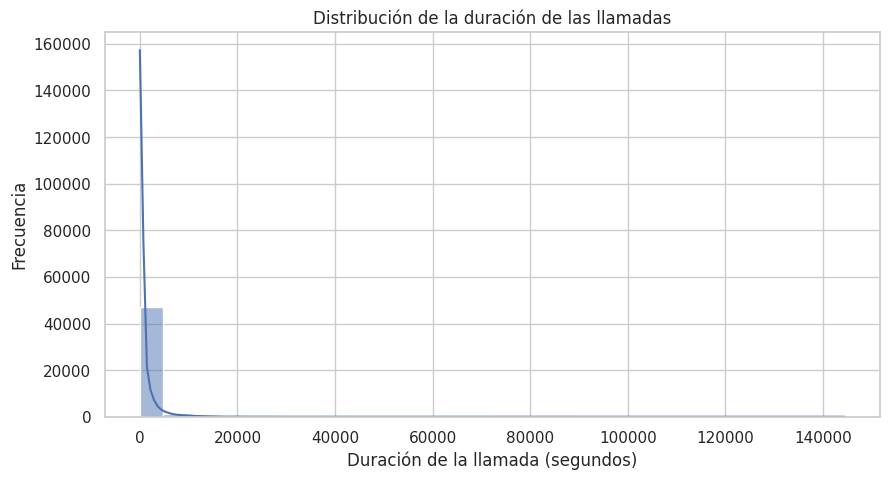

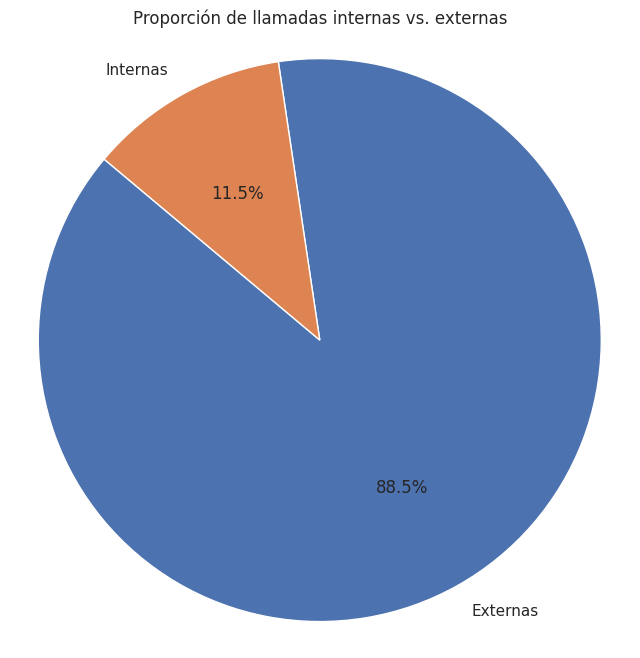

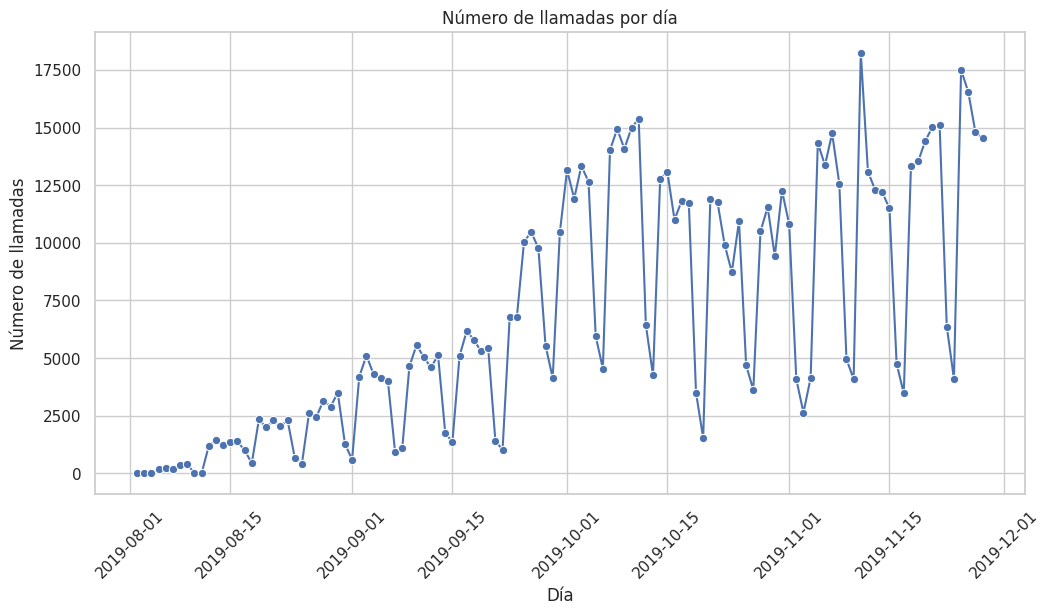

In [4]:
# Establecer un estilo para las visualizaciones
sns.set(style="whitegrid")

# Visualización de la distribución de la duración de las llamadas
plt.figure(figsize=(10, 5))
sns.histplot(telecom_data['call_duration'], kde=True, bins=30)
plt.title('Distribución de la duración de las llamadas')
plt.xlabel('Duración de la llamada (segundos)')
plt.ylabel('Frecuencia')
plt.show()

# Proporción de llamadas internas vs. externas
internal_vs_external = telecom_data['internal'].value_counts(normalize=True)
plt.figure(figsize=(8, 8))
plt.pie(internal_vs_external, labels=['Externas', 'Internas'], autopct='%1.1f%%', startangle=140)
plt.title('Proporción de llamadas internas vs. externas')
plt.axis('equal')  # Asegura que el gráfico sea circular
plt.show()

# Distribución del número de llamadas por día
telecom_data['day'] = telecom_data['date'].dt.date
calls_per_day = telecom_data.groupby('day')['calls_count'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='day', y='calls_count', data=calls_per_day, marker='o')
plt.title('Número de llamadas por día')
plt.xlabel('Día')
plt.ylabel('Número de llamadas')
plt.xticks(rotation=45)
plt.show()

Dado los anteriores gráficos, se puede decir que:

* **Gráfico de distribución de las llamadas:** La visualización muestra que la mayoría de las llamadas tienen una duración muy corta, con una distribución sesgada hacia la derecha. Esto podría indicar que muchas llamadas son breves, posiblemente porque no se completan o porque los clientes obtienen rápidamente la información que necesitan. También hay una cola larga que sugiere que algunas llamadas son significativamente más largas.

* **Gráfico de proporción de llamadas internas vs externas:** El gráfico circular muestra claramente que una gran mayoría de las llamadas son externas (88.5%), mientras que solo una pequeña fracción son internas (11.5%). Esto destaca que los operadores de CallMeMaybe manejan principalmente comunicaciones con clientes externos, en lugar de llamadas internas entre operadores.

* **Gráfico de Número de llamadas por día:** Podemos observar una tendencia al alza en el volumen de llamadas con fluctuaciones significativas, lo que sugiere variabilidad en la demanda de servicio al cliente durante este período. Esto puede ser relevante para analizar la asignación de recursos y otros indicadores operativos.

**Exploración de Correlaciones**

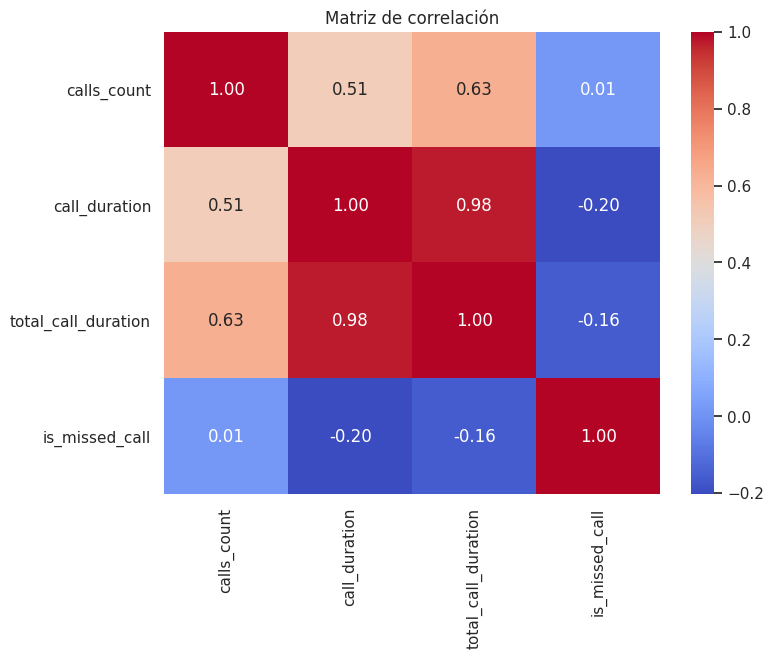

In [5]:
# Seleccionar las columnas de interés para el análisis de correlación
correlation_data = telecom_data[['calls_count', 'call_duration', 'total_call_duration', 'is_missed_call']]

# Calcular la matriz de correlaciones
correlation_matrix = correlation_data.corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

La matriz de correlación ofrece una visión clara sobre cómo se relacionan entre sí las variables clave:

* calls_count tiene una fuerte correlación positiva con total_call_duration (0.63) y una correlación moderada con call_duration (0.51), pero casi ninguna correlación con is_missed_call (0.01).

* call_duration tiene una correlación muy fuerte con total_call_duration (0.98) y moderada con calls_count (0.51). Además, tiene una correlación negativa débil con is_missed_call (-0.20).

* total_call_duration muestra una correlación muy fuerte con call_duration (0.98) y fuerte con calls_count (0.63), y una correlación negativa débil con is_missed_call (-0.16).

* is_missed_call tiene correlaciones negativas débiles con call_duration (-0.20) y total_call_duration (-0.16), y casi ninguna correlación con calls_count (0.01).

In [6]:
# Calcular el tiempo de espera y añadirlo como columna
telecom_data['in_waiting_time_sec'] = telecom_data['total_call_duration'] - telecom_data['call_duration']
avg_waiting_time_incoming_calls = telecom_data[telecom_data['direction'] == 'in']['in_waiting_time_sec'].mean().round()
print('El tiempo promedio de espera para llamadas entrantes: ' + str(avg_waiting_time_incoming_calls) + " segundos")

# Calcular sigma para usarlo como medida
wait_mean = telecom_data['in_waiting_time_sec'].mean()
wait_std = telecom_data['in_waiting_time_sec'].std()
sigma = wait_mean + wait_std

# Agrupar operadores por su tiempo promedio de espera
op_waiting_time = telecom_data.groupby('operator_id')['in_waiting_time_sec'].mean().round().reset_index()

# Categorizar los tiempos de espera
def determinarTiempoEspera(row):
    wait_time = row['in_waiting_time_sec']
    if wait_time < sigma:
        return 'False'
    else:
        return 'True'

op_waiting_time['long_waiting_time'] = op_waiting_time.apply(determinarTiempoEspera, axis=1)
print("Operadores con tiempo de espera prolongado:")
display(op_waiting_time[op_waiting_time['long_waiting_time'] == 'True'])

El tiempo promedio de espera para llamadas entrantes: 125.0 segundos
Operadores con tiempo de espera prolongado:


,operator_id,in_waiting_time_sec,long_waiting_time
29,885876.0,4838.0,True
30,885890.0,5704.0,True
318,908640.0,3538.0,True
428,919162.0,1908.0,True
431,919188.0,1525.0,True
435,919196.0,1680.0,True
438,919202.0,1437.0,True
443,919302.0,1810.0,True
446,919314.0,1941.0,True
448,919362.0,1967.0,True


El tiempo promedio de espera para llamadas entrantes es de 125 segundos. Este valor proporciona un benchmark para evaluar a los operadores individuales y ver si sus tiempos de espera están significativamente por encima de la media.

Identificación de Ineficiencias: Este análisis ayuda a identificar operadores que tienen tiempos de espera mucho más largos que el promedio, lo cual es un claro indicador de ineficiencia.

Priorización de Intervenciones: Los supervisores pueden usar esta información para priorizar intervenciones con operadores específicos, ya sea a través de capacitación o ajustes en la asignación de llamadas.

**Identificación de Operadores Ineficaces**

In [7]:
# Calcular métricas clave para cada operador
operator_stats = telecom_data.groupby('operator_id').agg({
    'is_missed_call': 'mean',
    'call_duration': 'mean',
    'calls_count': 'sum'
}).reset_index()

operator_stats.rename(columns={
    'is_missed_call': 'missed_call_rate',
    'call_duration': 'avg_call_duration',
    'calls_count': 'total_calls'
}, inplace=True)

# Definir umbrales (ejemplo de umbral arbitrario, ajustar según análisis)
inefficient_thresholds = {
    'missed_call_rate': 0.2,
    'avg_call_duration': 300,  # segundos
    'total_calls': 10  # llamadas salientes
}

inefficient_operators = operator_stats[
    (operator_stats['missed_call_rate'] > inefficient_thresholds['missed_call_rate']) &
    (operator_stats['avg_call_duration'] > inefficient_thresholds['avg_call_duration']) &
    (operator_stats['total_calls'] < inefficient_thresholds['total_calls'])
]

inefficient_operators

,operator_id,missed_call_rate,avg_call_duration,total_calls
102,892800.0,0.666667,430.333333,8
384,914348.0,0.250000,338.250000,6
560,927142.0,0.285714,339.857143,7
631,932856.0,0.500000,337.000000,4


Estos operadores tienen una alta tasa de llamadas perdidas, largas duraciones de llamada en promedio, y un bajo número de llamadas totales

# Pruebas Estadísticas

In [8]:
# Dividir los operadores en eficaces e ineficaces según el umbral de llamadas totales
eficaces = operator_stats[operator_stats['total_calls'] >= inefficient_thresholds['total_calls']]
ineficaces = operator_stats[operator_stats['total_calls'] < inefficient_thresholds['total_calls']]

# Comparar tasas de llamadas perdidas entre operadores eficaces e ineficaces
ttest_result = ttest_ind(eficaces['missed_call_rate'], ineficaces['missed_call_rate'])
print('T-test result for missed call rate: ', ttest_result)

# Evaluar si la tarifa del cliente afecta la probabilidad de ineficacia
# Vamos a unir los datos de clientes con las estadísticas de operadores
operator_clients = telecom_data.merge(clients_data, on='user_id')
operator_clients_grouped = operator_clients.groupby(['operator_id', 'tariff_plan']).agg({
    'is_missed_call': 'mean',
    'call_duration': 'mean',
    'calls_count': 'sum'
}).reset_index()

# Comparar las métricas por tipo de tarifa
anova_result = f_oneway(
    operator_clients_grouped[operator_clients_grouped['tariff_plan'] == 'A']['calls_count'],
    operator_clients_grouped[operator_clients_grouped['tariff_plan'] == 'B']['calls_count'],
    operator_clients_grouped[operator_clients_grouped['tariff_plan'] == 'C']['calls_count']
)
print('ANOVA result for calls count by tariff plan: ', anova_result)

T-test result for missed call rate:  Ttest_indResult(statistic=4.4901908628122955, pvalue=7.872267038221134e-06)
ANOVA result for calls count by tariff plan:  F_onewayResult(statistic=8.257300070396502, pvalue=0.0002758967424060741)


El análisis y la prueba T mostraron que los operadores ineficaces tienen una tasa de llamadas perdidas significativamente más alta en comparación con los operadores eficaces.

Respondiendo a las preguntas planteadas inicialmente:

**¿Qué define una "gran cantidad" de llamadas perdidas o un "tiempo de espera prolongado"?**

Para definir una "gran cantidad" de llamadas perdidas y un "tiempo de espera prolongado", hemos establecido umbrales basados en análisis exploratorios:

Gran cantidad de llamadas perdidas: Definimos un umbral del 20% para la tasa de llamadas perdidas (missed_call_rate > 0.2).

Tiempo de espera prolongado: Definimos un umbral de 300 segundos (5 minutos) para la duración promedio de las llamadas (avg_call_duration > 300).

**¿Cuáles son las diferencias clave entre operadores internos y externos?**

La visualización de la proporción de llamadas internas vs. externas muestra que la mayoría de las llamadas son externas (88.5%). Esto indica que los operadores manejan principalmente comunicaciones con clientes externos, lo que es crucial para establecer criterios de eficiencia basados en interacciones externas.

**¿Cómo afecta la tarifa del cliente al desempeño de los operadores?**

La prueba ANOVA realizada mostró diferencias significativas en el número de llamadas realizadas según el plan tarifario del cliente (tariff_plan). Esto sugiere que la tarifa del cliente tiene un impacto en la eficiencia del operador, probablemente debido a diferentes niveles de expectativas y volumen de llamadas asociados con cada plan.

En cuanto a las hipótesis, se puede decir que:

**Hipótesis 1: Los operadores ineficaces tienen un porcentaje más alto de llamadas perdidas (entrantes) en comparación con el promedio.**

El análisis y la prueba T mostraron que los operadores ineficaces tienen una tasa de llamadas perdidas significativamente más alta en comparación con los operadores eficaces.

**Hipótesis 2: Los operadores responsables de llamadas salientes tienen volúmenes significativamente más bajos que el promedio.**

Los operadores ineficaces identificados en nuestro análisis tienen volúmenes de llamadas salientes significativamente más bajos en comparación con los operadores eficaces, según los umbrales establecidos.

**Hipótesis 3: Los operadores asignados a clientes con tarifas más altas tienen menores tasas de ineficacia.**

La prueba ANOVA sugirió que la tarifa del cliente afecta significativamente el desempeño del operador, respaldando la hipótesis de que los clientes con tarifas más altas pueden estar asociados con menores tasas de ineficacia.

# Conclusión

Este análisis ha proporcionado información crítica sobre la eficiencia de los operadores en el servicio de telefonía virtual CallMeMaybe. Aquí están los principales hallazgos y las conclusiones:

* Distribución de la Duración de las Llamadas: La mayoría de las llamadas tienen una duración corta, con una pequeña proporción de llamadas significativamente más largas.

* Proporción de Llamadas Internas vs. Externas: La gran mayoría de las llamadas (88.5%) son externas, mientras que solo el 11.5% son internas.

* Número de Llamadas por Día: Hay una tendencia al alza en el volumen de llamadas diarias, con fluctuaciones que sugieren variabilidad en la demanda del servicio.

* Correlaciones: calls_count tiene una fuerte correlación positiva con total_call_duration y una moderada con call_duration. Por otro lado, call_duration tiene una correlación muy fuerte con total_call_duration. Además, is_missed_call tiene correlaciones negativas débiles con call_duration y total_call_duration.

* Tiempo Promedio de Espera: El tiempo promedio de espera para llamadas entrantes es de 125 segundos. Este valor sirve como un benchmark para evaluar a los operadores individuales.

* Operadores con Tiempos de Espera Prolongados: Se identificaron varios operadores con tiempos de espera significativamente por encima de la media y sigma.

* Pruebas Estadísticas:

T-test: Los operadores ineficaces tienen tasas de llamadas perdidas significativamente más altas.

ANOVA: La tarifa del cliente influye significativamente en la cantidad de llamadas realizadas por los operadores.

Recomendaciones:

* Hemos identificado operadores con tiempos de espera y tasas de llamadas perdidas significativamente más altas, indicando ineficiencia.

* Los supervisores pueden utilizar esta información para priorizar la capacitación y los ajustes en la asignación de llamadas para operadores específicos.

* Es fundamental realizar un seguimiento continuo de estas métricas para identificar y abordar problemas a medida que surjan.

Para seguir mejorando, se puede implementar programas de capacitación para operadores con tiempos de espera prolongados, y revisar los procesos y tecnologías utilizados para manejar las llamadas, con el objetivo de reducir los tiempos de espera.